In [ ]:
pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 4.7 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm


import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from collections import Counter
from string import punctuation

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score , f1_score, accuracy_score,confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from gensim.models import Word2Vec
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader , TensorDataset
from torchsummary import summary
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

lemma = WordNetLemmatizer()
lb = LabelEncoder()
nlp=spacy.load("en_core_web_lg")

OSError: ignored

In [ ]:
import spacy
from spacy import displacy
spacy.cli.download("en_core_web_lg")

In [ ]:
# Mengunduh library NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DATASET CB/Cyberbullying_Classification.csv')
df.head()

,tweet_text,cyberbullying_type,label
0,"In other words #katandandre, your food was cra...",not_cyberbullying,0
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,0
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,0
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,0


In [ ]:
df.isnull().sum()

tweet_text            0
cyberbullying_type    0
label                 0
dtype: int64

In [ ]:
np.unique(df['cyberbullying_type'])

array(['age', 'ethnicity', 'gender', 'not_cyberbullying',
       'other_cyberbullying', 'religion'], dtype=object)

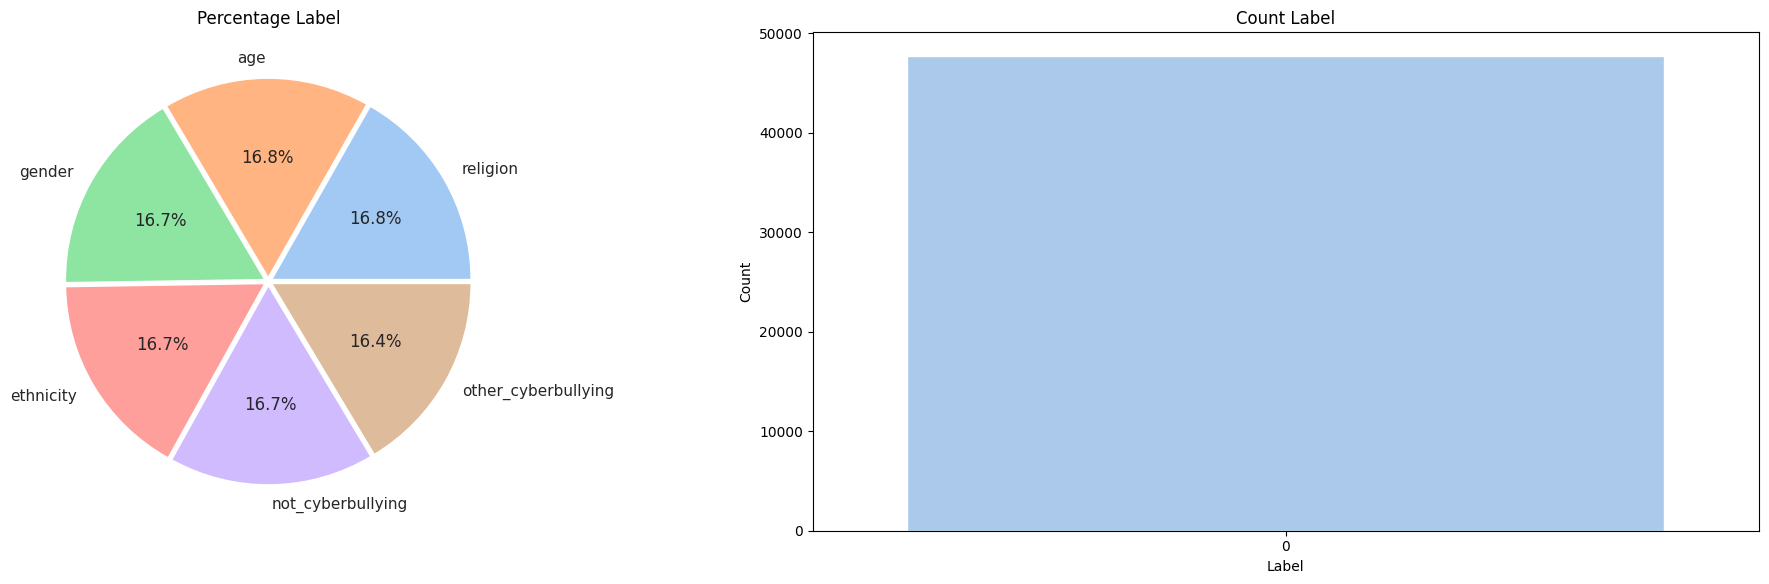

In [ ]:
label_count = df['cyberbullying_type'].value_counts()
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

sns.set_theme(style='darkgrid', palette='pastel')
color = sns.color_palette(palette='pastel')
explode = [0.02]*len(label_count)

axes[0].pie(label_count.values, labels=label_count.index, autopct='%1.1f%%', colors=color, explode=explode)
axes[0].set_title('Percentage Label')

sns.countplot(df['label'] , ax=axes[1])
axes[1].set_title('Count Label')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [ ]:
def Most_Words_used(tweets , num_of_words) :
    all_text = ''.join(df[tweets].values)

    all_text = re.sub(r'http\S+', '', all_text)
    all_text = re.sub(r'@\S+', '', all_text)
    all_text = re.sub(r'#\S+', '', all_text)
    all_text = re.sub(r'\d+', '',all_text)
    all_text = re.sub(r'[^\w\s]', '',all_text)


    words = all_text.split()

    stop_words = set(stopwords.words('english'))
    words = [word for word in words if not word in stop_words]

    word_counts = Counter(words)

    top_words = word_counts.most_common(num_of_words)

    return top_words

In [ ]:
def DataPrep(text) :
    text = re.sub('<.*?>', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'#\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)

    tokens = nltk.word_tokenize(text)

    #remove puncs
    punc = list(punctuation)
    words = [w for w in tokens if w not in punc]

    #remove stop words
    stop_words = set(stopwords.words('english'))
    words = [w.lower() for w in words if not w.lower() in stop_words]

    # lemmatization
    words = [lemma.lemmatize(w) for w in words]

    text = ' '.join(words)

    return text

In [ ]:
df['cleaned_text'] = df['tweet_text'].apply(DataPrep)

In [ ]:
print(f'There are around {int(df["cleaned_text"].duplicated().sum())} duplicated tweets, we will remove them.')

There are around 3174 duplicated tweets, we will remove them.


In [ ]:
df.drop_duplicates("cleaned_text", inplace=True)

In [ ]:
print(df['tweet_text'])

0        In other words #katandandre, your food was cra...
1        Why is #aussietv so white? #MKR #theblock #ImA...
2        @XochitlSuckkks a classy whore? Or more red ve...
3        @Jason_Gio meh. :P  thanks for the heads up, b...
4        @RudhoeEnglish This is an ISIS account pretend...
                               ...                        
47687    Black ppl aren't expected to do anything, depe...
47688    Turner did not withhold his disappointment. Tu...
47689    I swear to God. This dumb nigger bitch. I have...
47690    Yea fuck you RT @therealexel: IF YOURE A NIGGE...
47691    Bro. U gotta chill RT @CHILLShrammy: Dog FUCK ...
Name: tweet_text, Length: 44518, dtype: object


In [ ]:
df['tweet_len'] = [len(text.split()) for text in df.cleaned_text]

In [ ]:
df = df[df['tweet_len'] < df['tweet_len'].quantile(0.999)]

In [ ]:
x_train , x_test , y_train , y_test = train_test_split(df['cleaned_text'] , df['label'] , train_size = 0.8)

In [ ]:
vectorizer = TfidfVectorizer()
vectorizer.fit_transform(x_train)
print("No. of feature words: ",len(vectorizer.get_feature_names_out()))

No. of feature words:  32474


In [ ]:
x_train = vectorizer.transform(x_train).toarray()
x_test = vectorizer.transform(x_test).toarray()

In [ ]:
train_vectors = pd.DataFrame(x_train,columns=vectorizer.get_feature_names_out())

In [ ]:
for i in range(5) :
    print(sorted(list(train_vectors.iloc[i,:]),reverse = True)[:20])
    print('--------------------------------------------------')

[0.5984900908984327, 0.4451825094569491, 0.39654900764378, 0.38669918910972423, 0.3699118355076169, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
--------------------------------------------------
[0.4750581919780719, 0.4750581919780719, 0.4195696712178858, 0.28237171125125504, 0.2666593503957504, 0.251243623409743, 0.24312092541520453, 0.2035364831721368, 0.14085090273492806, 0.13955893452100013, 0.13706134147875348, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
--------------------------------------------------
[0.6340351135789949, 0.4261572966214832, 0.4064803970782663, 0.29899134073045536, 0.2908802648534844, 0.2777696343432929, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
--------------------------------------------------
[0.44982867192937886, 0.3019310218700679, 0.29595933475434455, 0.295053515350494, 0.29357088181312324, 0.2813791880037237, 0.2590576994531879, 0.2502798924999559, 0.24394349236733745, 0.2241925888928754, 0.2079

In [ ]:
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

In [ ]:
lr = LogisticRegression(random_state=42)
lr.fit(x_train , y_train)

LogisticRegression(random_state=0)

In [ ]:
train_acc1 = lr.score(x_train , y_train)

In [ ]:
lr_pred = lr.predict(x_test)

test_acc1 = accuracy_score(y_test , lr_pred)

test_precision1 = precision_score(y_test , lr_pred , average='weighted')
test_recall1 = recall_score(y_test , lr_pred , average='weighted')
test_f1score1 = f1_score(y_test , lr_pred , average='weighted')

In [ ]:
print(f"The training accuracy for logistic regression : {(train_acc1*100):0.2f}%\n")
print(f"The testing accuracy for logistic regression : {(test_acc1*100):0.2f}%\n")
print(f"The precision for logistic regression : {test_precision1:0.2f}\n")
print(f"The recall for logistic regression : {test_recall1:0.2f}\n")
print(f"The f1 score for logistic regression : {test_f1score1:0.2f}\n")

The training accuracy for logistic regression : 90.69%

The testing accuracy for logistic regression : 86.15%

The precision for logistic regression : 0.85

The recall for logistic regression : 0.86

The f1 score for logistic regression : 0.85



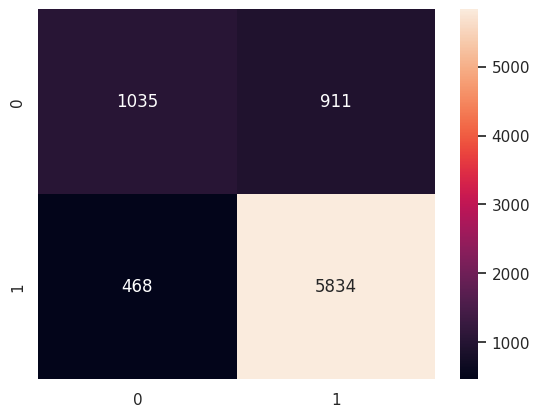

In [ ]:
lr_cm = confusion_matrix(y_test , lr_pred)
sns.heatmap(lr_cm, annot=True,fmt='3g')
plt.show()

In [ ]:
rf = RandomForestClassifier(random_state=42)
rf.fit(x_train , y_train)

RandomForestClassifier(random_state=42)

In [ ]:
train_acc2 = rf.score(x_train , y_train)

In [ ]:
rf_pred = rf.predict(x_test)

test_acc2 = accuracy_score(y_test , lr_pred)

test_precision2 = precision_score(y_test , rf_pred , average='weighted')
test_recall2 = recall_score(y_test , rf_pred , average='weighted')
test_f1score2 = f1_score(y_test , rf_pred , average='weighted')


In [ ]:
print(f"The training accuracy for Random Forest : {(train_acc2*100):0.2f}%\n")
print(f"The testing accuracy for Random Forest : {(test_acc2*100):0.2f}%\n")
print(f"The precision for Random Forest : {test_precision2:0.2f}\n")
print(f"The recall for Random Forest : {test_recall2:0.2f}\n")
print(f"The f1 score for Random Forest : {test_f1score2:0.2f}\n")

The training accuracy for Random Forest : 99.98%

The testing accuracy for Random Forest : 86.25%

The precision for Random Forest : 0.85

The recall for Random Forest : 0.87

The f1 score for Random Forest : 0.85

